# Gesture Recognition CNN + RNN
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import imageio
#img = imageio.imread('your_image.jpg')
import datetime
import os

#CNN
from tensorflow import keras																										
from tensorflow.keras import layers, optimizers																										
from tensorflow.keras.layers import Input, Add,Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D																										
from tensorflow.keras.models import Model, load_model																										
from tensorflow.keras.preprocessing import image																										
from tensorflow.keras.utils import plot_model																										
from tensorflow.keras.applications.imagenet_utils import preprocess_input																										
from tensorflow.keras.initializers import glorot_uniform																										
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array																										
from tensorflow.keras.applications import ResNet50																										
from tensorflow.keras.applications.resnet50 import preprocess_input																										


#RNN -includes
from nltk.corpus import brown					
from nltk.corpus import treebank					
from nltk.corpus import conll2000					
import seaborn as sns					
from gensim.models import KeyedVectors					
from tensorflow.keras.preprocessing.sequence import pad_sequences					
from tensorflow.keras.utils import to_categorical					
from tensorflow.keras import Sequential, Input, Model					
from tensorflow.keras.layers import Embedding, Dense, TimeDistributed, LSTM, GRU, Bidirectional, SimpleRNN, RNN					
from tensorflow.keras.preprocessing.text import Tokenizer					
from sklearn.model_selection import train_test_split					
from sklearn.utils import shuffle					


#common includes
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
#from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dense, GlobalAveragePooling2D

import cv2
# Read the image
#img = cv2.imread('image.jpg')
# Resize the image to half its original size
#resized_img = cv2.resize(img, None, fx=0.5, fy=0.5)
# Resize the image to a specific size (300x200 pixels)
#resized_img = cv2.resize(img, (300, 200))
# Display the resized image
#cv2.imshow('Resized Image', resized_img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [2]:
#!pip install imageio

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(42) 

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('Gesture_Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Gesture_Project_data/val.csv').readlines())


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
img_idx = [num for num in range(30)]
#img_idx =  img_idx[::2]
#img_idx

In [6]:
new_width  =  120
new_height = 120
#img_idx = [num for num in range(30)]
#img_idx =  img_idx[::5] #only 5 images to start with
time_dimen = len(img_idx)
print("Time Dimen :", time_dimen)
#num_batches = 50
batch_size = 50 #experiment with the batch size
num_channels = 3
num_classes = 5
num_epochs = 50 # It should be 50 / 100
train_path = './Gesture_Project_data/train'
val_path = './Gesture_Project_data/val'


Time Dimen : 30


In [7]:
def generator(source_path, folder_list, batch_size, total_seq) : 
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #create a list of image numbers you want to use for a particular video
    #img_idx = img_idx = [num for num in range(30)]
    #img_idx =  img_idx[::5] #only 5 images to start with
    img_idx = [num for num in range(30)]
    img_idx =  img_idx[::5] #only 5 images to start with
    time_dimen = len(img_idx)
    img_idx = img_idx
    #num_batches = (int) (total_seq / batch_size )
    new_width  =  120
    new_height = 120
    while True:
        t = np.random.permutation(folder_list)
        num_batches = (int) (total_seq / batch_size ) # start with 1 batch once --calculate the number of batches
        #print("Num Batches :",num_batches)
        for batch in range(num_batches): # we iterate over the number of batches
            #batch_size - Batch Size / Number of batches
            #x - Number of images / Number of time steps in video sequence
            #y - image size x
            #z - image size y
            #3 - RGB channel
            x = time_dimen
            y = new_height
            z = new_height
            #print("batch :",batch)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,num_classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                #print("batch*batch_size : ",batch*batch_size)
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    image = cv2.resize(image, (new_width, new_height))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # Convert the image to float32
                    image = image.astype(np.float32)
                    # Normalize the image to the range [0, 1]
                    normalized_img = image / 255.0
                    # Display or save the normalized image
                    #cv2.imshow('Normalized Image', normalized_img)
                    #cv2.waitKey(0)
                    #cv2.destroyAllWindows()
                    imageR = normalized_img[:, :, 0] 
                    imageG = normalized_img[:, :, 1] 
                    imageB = normalized_img[:, :, 2]
                    #imageR=imageR.astype(np.float32)
                    #imageR = imageR / 255.0
                    #imageG=imageG.astype(np.float32)
                    #imageG = imageG / 255.0
                    #imageB=imageB.astype(np.float32)
                    #imageB = imageB / 255.0                    
                    batch_data[folder,idx,:,:,0] = imageR  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = imageG  #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = imageB  #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        if (total_seq%batch_size) > 0: #remaining delta elements             
            new_batch_size = total_seq%batch_size
            #print("New Batch Size",new_batch_size)
            x = time_dimen
            y = new_height
            z = new_height
            last_batch_data = np.zeros((new_batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            last_batch_labels = np.zeros((new_batch_size,num_classes)) # batch_labels is the one hot representation of the output
            for folder in range(new_batch_size): # iterate over the batch_size
                #print("num_batches*batch_size : ",num_batches*batch_size)
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    image = cv2.resize(image, (new_width, new_height))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # Convert the image to float32
                    image = image.astype(np.float32)
                    # Normalize the image to the range [0, 1]
                    normalized_img = image / 255.0
                    # Display or save the normalized image
                    #cv2.imshow('Normalized Image', normalized_img)
                    #cv2.waitKey(0)
                    #cv2.destroyAllWindows()
                    imageR = normalized_img[:, :, 0] 
                    imageG = normalized_img[:, :, 1] 
                    imageB = normalized_img[:, :, 2]
                    #imageR=imageR.astype(np.float32)
                    #imageR = imageR / 255.0
                    #imageG=imageG.astype(np.float32)
                    #imageG = imageG / 255.0
                    #imageB=imageB.astype(np.float32)
                    #imageB = imageB / 255.0                    
                    last_batch_data[folder,idx,:,:,0] = imageR  #normalise and feed in the image
                    last_batch_data[folder,idx,:,:,1] = imageG  #normalise and feed in the image
                    last_batch_data[folder,idx,:,:,2] = imageB  #normalise and feed in the image
                last_batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
                #print("Last Batch Lables : ",batch_labels)
            yield last_batch_data, last_batch_labels #you yield the batch_data and the batch_labels, remember what does yield do        
        # write the code for the remaining data points which are left after full batches


In [8]:
train_generator = generator(train_path, train_doc, batch_size, len(train_doc))
val_generator = generator(val_path, val_doc, batch_size, len(val_doc))

In [9]:
# Test the Generator code
total_seq = len(train_doc) # total number of data sets
total_num_batches= 0 ;
if (total_seq%batch_size) == 0:
    total_num_batches =(int) (total_seq/batch_size)
else:
    total_num_batches = (total_seq//batch_size) + 1
    
print("Total Num of Training Batches :",total_num_batches)
batch_data = []
for count in range(total_num_batches) : 
    batch_data = next(train_generator)
print("Last Batch Size of batch_data:",len(batch_data[0]))
print("Last Batch Size of batch_labels",len(batch_data[1]))
# Test the Generator code
total_seq = len(val_doc) # total number of data sets
total_num_batches= 0 ;
if (total_seq%batch_size) == 0:
    total_num_batches =(int) (total_seq/batch_size)
else:
    total_num_batches = (total_seq//batch_size) + 1
    
print("Total Number of Validation Batches :",total_num_batches)
batch_data = []
for count in range(total_num_batches) : 
    batch_data = next(val_generator)
print("Last Batch Size of batch_data:",len(batch_data[0]))
print("Last Batch Size of batch_labels",len(batch_data[1]))

Total Num of Training Batches : 14
Source path =  ./Gesture_Project_data/train ; batch size = 50
Last Batch Size of batch_data: 13
Last Batch Size of batch_labels 13
Total Number of Validation Batches : 2
Source path =  ./Gesture_Project_data/val ; batch size = 50
Last Batch Size of batch_data: 50
Last Batch Size of batch_labels 50


In [10]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.


Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

In [25]:
# CNN Layers
#A 3D convolutional layer expects a 5D input tensor with the shape: (batch_size, time_steps, height, width, channels).			
# Here we are using ResNet50 as base pretrained model			

# Define the input layer -- we need 5 D tensor : time, batch, image height, image weight, color channels with batch size)
print("Batch Size:",batch_size)
input_layer = Input(shape=(time_dimen, new_width, new_height, 3), batch_size=batch_size)  # None is the sequence length (time_steps)

base_model = ResNet50(weights='imagenet', include_top=False)												
												
# As we are using ResNet model only for feature extraction and not adjusting the weights												
for layer in base_model.layers:												
 	layer.trainable = False	

# we freeze the first 40 layers in base model												
#for layer in base_model.layers[:40]:  # Adjust number based on architecture
#    layer.trainable = False
										
# Get base model output 												
base_model_ouput = base_model.output												
												
# Adding our own layer 	

# Adding our own CNN layers
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(base_model_ouput)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)

# x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)

# x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)

# x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)

# Adding GlobalAveragePooling and Fully Connected layers
x=GlobalAveragePooling2D()(x)
# Adding fully connected layer
#x=Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
x = Dense(2000, activation='relu')(x)
cnn_model = Model(inputs=base_model.input, outputs=x)	

# Print CNN model summary
cnn_model.summary()

# Access the output shape CNN layer
layer_output_shape = cnn_model.layers[-1].output_shape
num_features = layer_output_shape[-1]  # Last dimension is the number of features
print("Number of features extracted:", num_features)


# Input layer for TimeDistributed
input_layer = Input(shape=(None, *base_model.input_shape[1:]))

# Apply CNN to each frame in the sequence using TimeDistributed
time_distributed_cnn = TimeDistributed(cnn_model)
extracted_features = time_distributed_cnn(input_layer)  # Connect to the input layer

# Apply CNN to each frame in the sequence using TimeDistributed
#time_distributed_cnn = TimeDistributed(cnn_model)
#extracted_features = time_distributed_cnn(input_layer)  # Connect to the input layer


# Add stacked LSTM layers for temporal modeling 
lstm_layer1 = LSTM(256, return_sequences=True, stateful=False)(extracted_features) 
lstm_layer2 = LSTM(128, return_sequences=True, stateful=False)(lstm_layer1)        # Stacked LSTM
lstm_layer3 = LSTM(64, return_sequences=False, stateful=False)(lstm_layer2)        # Final LSTM, no sequence output
 

# Classification Layer
num_classes = num_classes  # Replace with the number of classes in your dataset
output_layer = Dense(num_classes, activation='softmax')(lstm_layer3)

# Wrap CNN in TimeDistributed to handle sequences of frames
#time_distributed_cnn = TimeDistributed(cnn_model)

# Define and compile the model CNN + RNN with 5 dimentional tensors
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print CNN+RNN model summary
model.summary()



Batch Size: 50
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_14[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                         


Let us create the train_generator and the val_generator which will be used in .fit_generator.

In [26]:
#train_generator = generator(train_path, train_doc, batch_size)
#val_generator = generator(val_path, val_doc, batch_size)

In [27]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = 'd:\\' + model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint =  tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

# write the REducelronplateau code here
#LR = 0.01
#callbacks_list = [checkpoint, LR]
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
#model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='my_model.h5', save_best_only=True)
callbacks_list = [early_stopping, checkpoint]

In [28]:
print(filepath)

d:\model_init_2024-12-0520_29_22.001437/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [29]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [30]:
print("Steps per epoch, num of training sequences and batch size : ",steps_per_epoch,num_train_sequences,batch_size)
print("Steps per epoch, num of validation sequences and batch size : ",validation_steps,num_val_sequences,batch_size)

Steps per epoch, num of training sequences and batch size :  14 663 50
Steps per epoch, num of validation sequences and batch size :  2 100 50


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [31]:
cnn_rnn_training = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 1.6133 - categorical_accuracy: 0.2097
Epoch 1: saving model to d:\model_init_2024-12-0520_29_22.001437\model-00001-1.61330-0.20965-1.55861-0.27000.keras
14/14 [==============================] - 52s 3s/step - loss: 1.6133 - categorical_accuracy: 0.2097 - val_loss: 1.5586 - val_categorical_accuracy: 0.2700
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 1.4850 - categorical_accuracy: 0.3318
Epoch 2: saving model to d:\model_init_2024-12-0520_29_22.001437\model-00002-1.48502-0.33183-1.49365-0.31000.keras
14/14 [==============================] - 40s 3s/step - loss: 1.4850 - categorical_accuracy: 0.3318 - val_loss: 1.4936 - val_categorical_accuracy: 0.3100
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 1.4408 - categorical_accuracy: 0.3122
Epoch 3: saving model to d:\model_init_2024-12-0520_29_22.001437\model-00003-1.44077-0.31222-1.39238-0.33000.keras
14/14 [========================

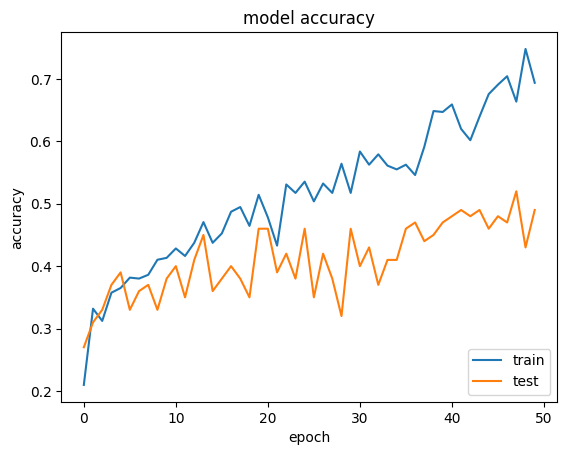

In [32]:
# visualise training history			
plt.plot(cnn_rnn_training.history['categorical_accuracy'])			
plt.plot(cnn_rnn_training.history['val_categorical_accuracy'])			
plt.title('model accuracy')			
plt.ylabel('accuracy')			
plt.xlabel('epoch')			
plt.legend(['train', 'test'], loc="lower right")			
plt.show()			
